## Position Estimator With ReID

In [1]:
from src.sensor import Camera

from src.sensor import mba_photo_camera
from src.sensor import mba_video_camera
from src.sensor import zed_two_camera
from src.sensor import yt_video_camera

from src.sensor import avg_torso_height
from src.sensor import avg_shoulder_width

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from src.point import Point
from src.vision import PositionEstimator, VideoCapture
import mediapipe as mp
from src.vision import VideoCapture
from src.vision import ObjectDetector
from src.vision import plot_obj
from ultralytics import YOLO
from src.vision import ReID
from src.vision import mask_frame
import time

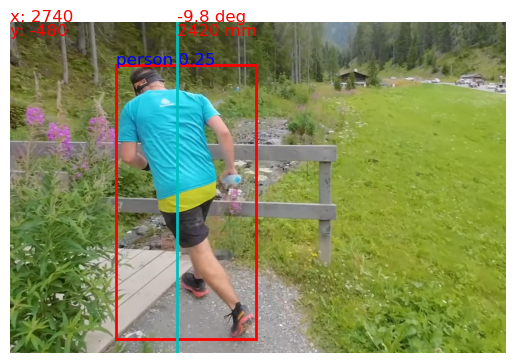

In [3]:
verbose = True
refresh_rate = 1
camera = yt_video_camera
yolo_model = YOLO('yolov8s.pt')
obj_detector = ObjectDetector(yolo_model, camera)
pe = PositionEstimator(
    mp.solutions.pose, 
    camera,
    avg_torso_height, 
    file_path='io/pe.csv',
    queue_size=3,
    kernel_size=3
)


try:
    # Initiate the camera
    # cap = VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    # cap = VideoCapture('./Movie on 2023-12-11 at 21.01.mov')
    # cap = VideoCapture('./Movie on 2023-12-11 at 21.02.mov')
    cap = VideoCapture('/Users/etiennecomtois/Pictures/Screenshots/Screen Recording 2023-12-16 at 01.40.23.mov')
    # https://www.youtube.com/watch?v=mCcEy6fZZ8I
    # cap = VideoCapture(0)
    time.sleep(1)

    # cap.skip_frames(14)
    frame = cap.grab_frame()
    crop = { 
        'ymin': 0, 
        'xmin': camera.h_res // 4, 
        'ymax': camera.v_res,
        'xmax': camera.h_res // 4 * 3,
    }
    frame = mask_frame(frame, crop)
    obj_detector.detect(mask_frame(frame, crop))
    host = obj_detector.get_objs_by_name('person', score=0.4).iloc[0]
    reid = ReID(frame, host, 32, 0.80)

    while True:
        start = time.time()
        cap.skip_frames(7)
        frame = cap.grab_frame()
        if frame is None: break
        
        obj_detector.detect(frame)
        objs = obj_detector.get_objs_by_name('person', score=0.4)
        host, objs = reid.reid(frame, objs)

        clear_output(wait=True)
        fig, ax = plt.subplots() if verbose else (None, None)

        if host is not None:
            bo_frame = mask_frame(frame, host)
            result = pe.save_position(bo_frame, 1.15, verbose=verbose)
            if result is not None and verbose:
                pe.plot_result(ax, frame, result, camera)
        else:
            pe.save_blank()

        ax.imshow(frame) if verbose else None
        # ax.imshow(bo_frame) if verbose else None

        if verbose:
            plot_obj(ax, host, 'r') if host is not None else None
            for index, obj in objs.iterrows():
                plot_obj(ax, obj, 'y')
            plt.axis('off')
            plt.show()

        delta = time.time() - start
        # print(f'FPS: {1/delta:.2f}')
        pause = (1 / refresh_rate) - delta
        if pause > 0: time.sleep(pause)
        delta = time.time() - start
        # print(f'FPS: {1/delta:.2f}')

except KeyboardInterrupt:
    cap.release()  # Release the camera resource

cap.release()  # Release the camera resource if break